In [3]:
import cv2 as cv
import numpy as np
from PIL import Image
from show_image import show_image

In [4]:
import glob
import os
import csv
import cv2
import collections
import random
import lmdb
import six
import sys
from PIL import Image
import numpy as np
import torch
from torch import optim
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
import torchvision.utils as vutils


In [5]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [6]:
#UTILS

class strLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts


class averager(object):
    """Compute average for `torch.Variable` and `torch.Tensor`. """

    def __init__(self):
        self.reset()

    def add(self, v):
        if isinstance(v, Variable):
            count = v.data.numel()
            v = v.data.sum()
        elif isinstance(v, torch.Tensor):
            count = v.numel()
            v = v.sum()

        self.n_count += count
        self.sum += v

    def reset(self):
        self.n_count = 0
        self.sum = 0

    def val(self):
        res = 0
        if self.n_count != 0:
            res = self.sum / float(self.n_count)
        return res


def oneHot(v, v_length, nc):
    batchSize = v_length.size(0)
    maxLength = v_length.max()
    v_onehot = torch.FloatTensor(batchSize, maxLength, nc).fill_(0)
    acc = 0
    for i in range(batchSize):
        length = v_length[i]
        label = v[acc:acc + length].view(-1, 1).long()
        v_onehot[i, :length].scatter_(1, label, 1.0)
        acc += length
    return v_onehot


def loadData(v, data):
    v.data.resize_(data.size()).copy_(data)


def prettyPrint(v):
    print('Size {0}, Type: {1}'.format(str(v.size()), v.data.type()))
    print('| Max: %f | Min: %f | Mean: %f' % (v.max().data[0], v.min().data[0],
                                              v.mean().data[0]))


def assureRatio(img):
    """Ensure imgH <= imgW."""
    b, c, h, w = img.size()
    if h > w:
        main = nn.UpsamplingBilinear2d(size=(h, h), scale_factor=None)
        img = main(img)
    return img

In [7]:
class resizeNormalize(object):

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        return img


class randomSequentialSampler(sampler.Sampler):

    def __init__(self, data_source, batch_size):
        self.num_samples = len(data_source)
        self.batch_size = batch_size

    def __iter__(self):
        n_batch = len(self) // self.batch_size
        tail = len(self) % self.batch_size
        index = torch.LongTensor(len(self)).fill_(0)
        for i in range(n_batch):
            random_start = random.randint(0, len(self) - self.batch_size)
            batch_index = random_start + torch.range(0, self.batch_size - 1)
            index[i * self.batch_size:(i + 1) * self.batch_size] = batch_index
        # deal with tail
        if tail:
            random_start = random.randint(0, len(self) - self.batch_size)
            tail_index = random_start + torch.range(0, tail - 1)
            index[(i + 1) * self.batch_size:] = tail_index

        return iter(index)

    def __len__(self):
        return self.num_samples


class alignCollate(object):

    def __init__(self, imgH=32, imgW=100, keep_ratio=False, min_ratio=1):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio = keep_ratio
        self.min_ratio = min_ratio

    def __call__(self, batch):
        images, labels = zip(*batch)

        imgH = self.imgH
        imgW = self.imgW
        if self.keep_ratio:
            ratios = []
            for image in images:
                w, h = image.size
                ratios.append(w / float(h))
            ratios.sort()
            max_ratio = ratios[-1]
            imgW = int(np.floor(max_ratio * imgH))
            imgW = max(imgH * self.min_ratio, imgW)  # assure imgH >= imgW

        transform = resizeNormalize((imgW, imgH))
        images = [transform(image) for image in images]
        images = torch.cat([t.unsqueeze(0) for t in images], 0)

        return images, labels

In [10]:
# load model
model_path = r'C:\Users\admin\Downloads\warp_netCRNN_50_469.pth'
alphabet = '0123456789,.:(%$!^&-/);<~|`>?+=_[]{}"\'@#*ABCDEFGHIJKLMNOPQRSTUVWXYZ\ '
imgH = 32 # should be 32
nclass = len(alphabet) + 1
nhiddenstate = 256

model = CRNN(imgH, 1, nclass, nhiddenstate)
if torch.cuda.is_available():
    model = model.cuda()
print('loading pretrained model from %s' % model_path)
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(model_path,map_location=torch.device('cpu')).items()})


loading pretrained model from C:\Users\admin\Downloads\warp_netCRNN_50_469.pth


<All keys matched successfully>

In [11]:
def predict_this_box(image, model, alphabet):
    converter = strLabelConverter(alphabet)
    transformer = resizeNormalize((200, 32))
    image = transformer(image)
    if torch.cuda.is_available():
        image = image.cuda()
    image = image.view(1, *image.size())
    image = Variable(image)

    model.eval()
    preds = model(image)

    _, preds = preds.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)

    preds_size = Variable(torch.IntTensor([preds.size(0)]))
    raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
    sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
    print('%-30s' % (sim_pred))
    return sim_pred

In [12]:
image  = r'D:\ICDAR-2019-SROIE\task1\data\images\X51009453801.jpg'

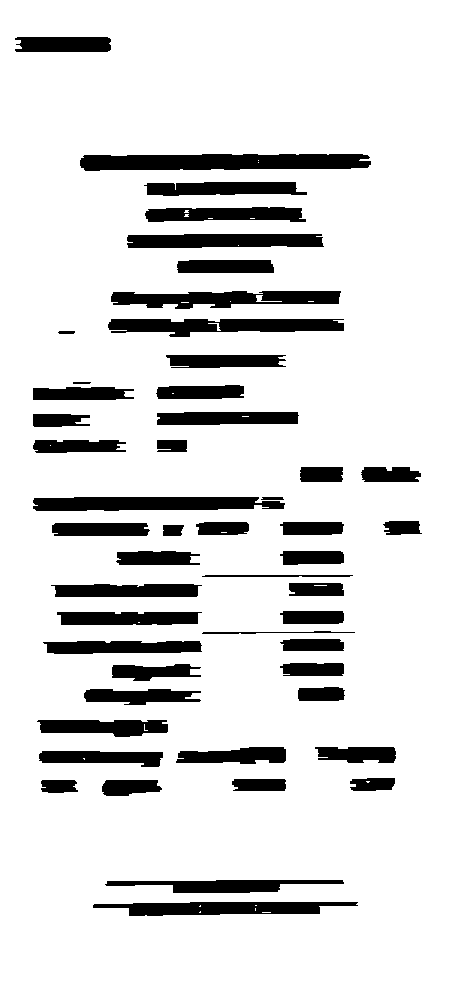

gl handicraft & tal orimg     


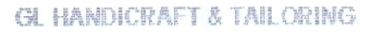

96.23                         


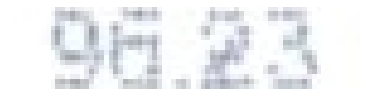

102.00                        


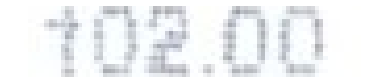

rm                            


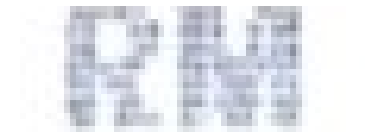

102.00                        


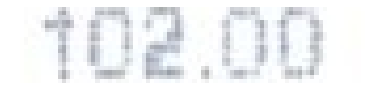

102.00                        


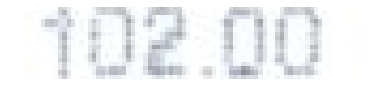

17.00                         


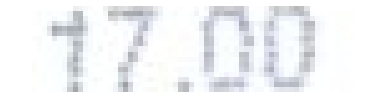

x                             


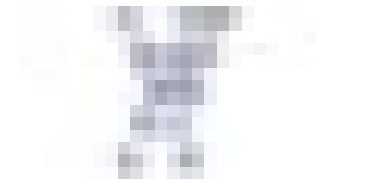

suptotel :                    


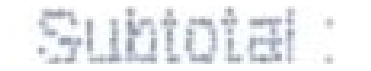

96.23                         


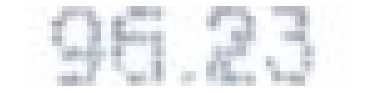

amount(rm)                    


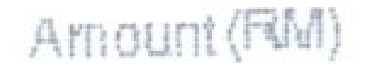

payment :                     


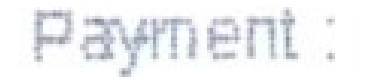

102.00                        


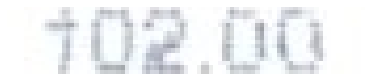

102.00                        


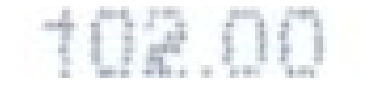

0.00                          


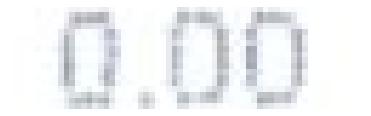

****i thank you ***           


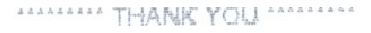

@ 5%                          


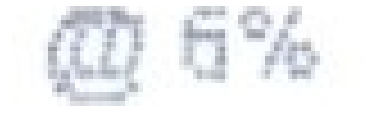

change due :                  


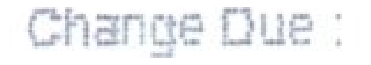

@#i#iw#m                      


imimnnn                       


total incl. of gst            


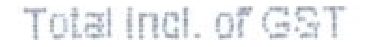

total excl. of gst            


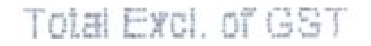

6.00 boas                     


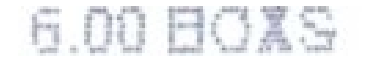

total amt rounded             


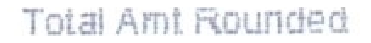

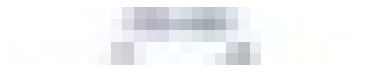

0t                            


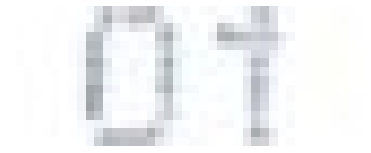

tax invoice                   


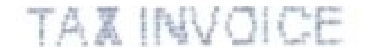

20/03/2018 13:01              


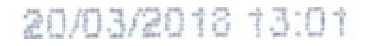

cs 10012                      


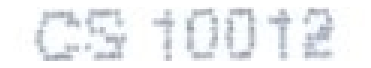

off jalanpudu,                


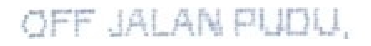

19, jalan kancil,             


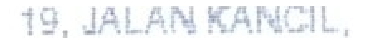

malaysia                      


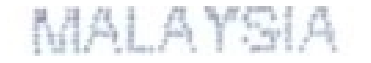

55100 kuala lumpur            


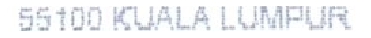

company reg no.:73492-w       


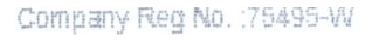

gst reg no. :001948532736     


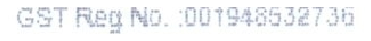

safety pins butterfly - s     


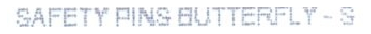

r"                            


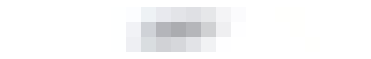

4                             


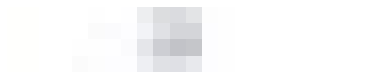

sr                            


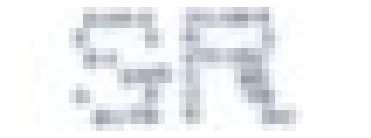

code                          


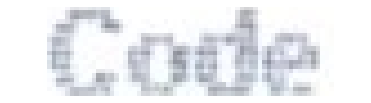

tax (rm)                      


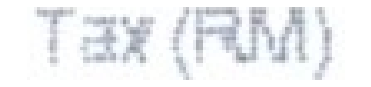

5.77                          


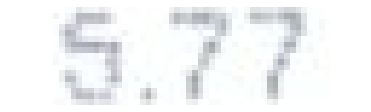

**lease come agan             


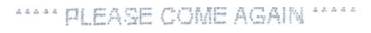

sr                            


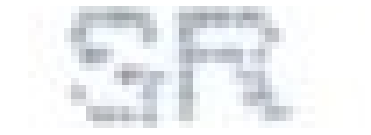

gst summany                   


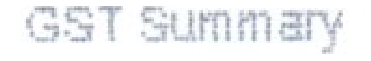

total item(5) 3 6             


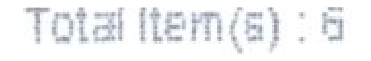

3180303                       


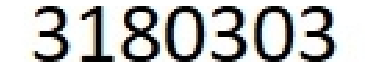

date:                         


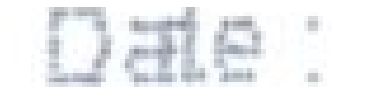

cashler #:                    


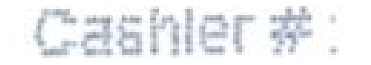

invoice no.i                  


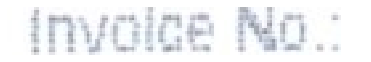

/:1                           


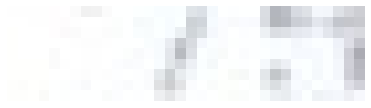

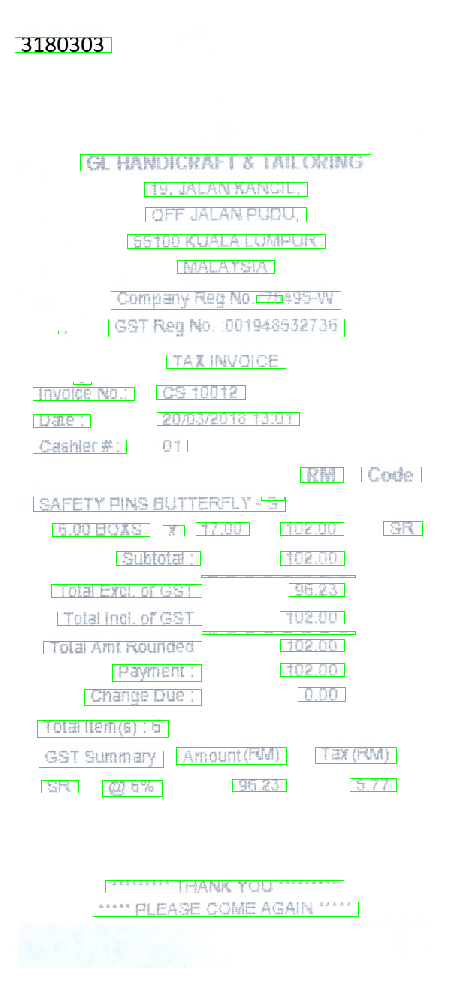

In [13]:
frame = cv2.imread(image)
image_obj = Image.open(image).convert('L')
#greyscale
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

#threshold
_, bw = cv2.threshold(gray, 0.0, 255.0, cv.THRESH_BINARY | cv2.THRESH_OTSU)
#show_image(bw,12,18)

# get horizontal mask of large size since text are horizontal components
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_ERODE, kernel)
#print("morphed")
show_image(connected,12,18)

#visualise text polygons
vis = frame.copy()
mser = cv2.MSER_create()
regions, _ = mser.detectRegions(gray)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0))
#show_image(vis,12,18)

#visualise text polygons
vis1 = frame.copy()
_, boundingboxes = mser.detectRegions(connected)
for box in boundingboxes:
    x,y,w,h = box
    roi=frame[y:y+h,x:x+w]
    pil_im = Image.fromarray(np.uint8(roi)).convert('L')
    words = predict_this_box(pil_im, model, alphabet)
    show_image(roi)
    cv2.rectangle(vis1,(x,y),(x+w,y+h),(0,255,0),1)
show_image(vis1,12,18)


#to visualise only text by letters
regions, _ = mser.detectRegions(gray)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0))
mask = np.zeros((frame.shape[0], frame.shape[1], 1), dtype=np.uint8)
for contour in hulls:
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)

#this is used to find only text regions, remaining are ignored
text_only = cv2.bitwise_and(frame, frame, mask=mask)
#show_image(text_only,12,18)

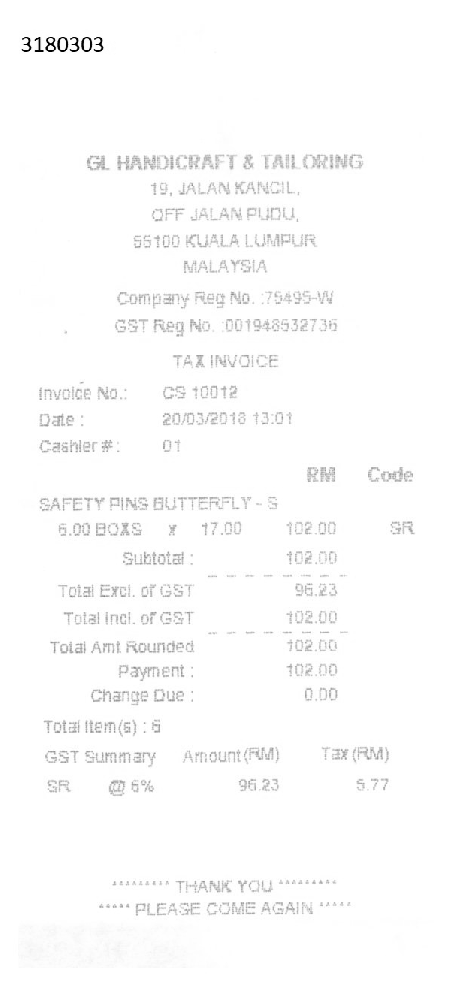

In [16]:
show_image(gray,12,18)